In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

color_pal = sns.color_palette()

In [2]:
#read X data
df_X = pd.read_csv('data/Germany/input_data.csv')
df_X = df_X.set_index('time')
df_X.index = pd.to_datetime(df_X.index)

In [3]:
df_X = df_X[(df_X.index>='2002-05-01' )& (df_X.index<='2016-12-31')]


for j in ['rr','tg','tn','tx','pp','hu','fg','qq','et']:
    temps = pd.DataFrame(df_X[j].values)
    shifted = temps.shift(1)
    for k in [15,30,90]:
        window, means, mins, maxs = {}, {}, {}, {}
        window["{}".format(k)] = shifted.rolling(window=k)
        means["{}".format(k)] = window["{}".format(k)].mean()
        df_X["{}_avg_{}".format(j,k)]=means["{}".format(k)].to_numpy()
    
#     for q in [7]:
#         window, means, mins, maxs = {}, {}, {}, {}
#         window["{}".format(q)] = shifted.rolling(window=q)
#         mins["{}".format(q)] = window["{}".format(q)].min()
#         df_X["{}_min_{}".format(j,q)]=mins["{}".format(q)].to_numpy()
#         maxs["{}".format(q)] = window["{}".format(q)].max()
#         df_X["{}_max_{}".format(j,q)]=maxs["{}".format(q)].to_numpy()
        

# drop first week of data after creating lag features
df_X.dropna(inplace = True)
print(df_X.shape)
df_X.head()

(5269, 36)


,rr,tg,tn,tx,pp,hu,fg,qq,et,rr_avg_15,...,hu_avg_90,fg_avg_15,fg_avg_30,fg_avg_90,qq_avg_15,qq_avg_30,qq_avg_90,et_avg_15,et_avg_30,et_avg_90
time,,,,,,,,,,,,,,,,,,,,,
2002-07-30,0.0,23.930000,17.449999,30.260000,1009.80000,62.815002,1.50,289.0,4.824051,3.526667,...,74.856288,2.140667,2.080000,2.160111,192.466667,208.800000,225.266667,2.879931,3.132310,3.318380
2002-07-31,1.4,22.340000,16.090000,28.930000,1006.60004,71.715004,1.83,245.0,3.991608,3.333333,...,74.770677,2.061333,2.081333,2.144778,203.466667,207.766667,226.200000,3.076729,3.143489,3.341253
2002-08-01,5.3,18.779999,15.929999,22.590000,1009.50000,85.365005,2.36,152.0,2.323265,2.926667,...,74.682066,2.042000,2.066000,2.135111,212.600000,207.433333,227.211111,3.233903,3.146277,3.363210
2002-08-02,0.0,17.650000,12.889999,23.680000,1014.60004,76.745000,1.89,266.0,3.969962,2.420000,...,74.631233,2.038667,2.087333,2.133667,216.866667,210.333333,227.766667,3.302663,3.193677,3.374144
2002-08-03,0.0,20.300000,12.840000,26.949999,1012.80000,71.470000,1.29,247.0,3.878862,1.526667,...,74.438082,1.958667,2.075333,2.128000,229.133333,211.833333,229.777778,3.493963,3.215200,3.406897


In [4]:
# # check for null values
# df_X[df_X['rr_avg_past_week'].isnull()]

In [5]:
#read y data
df_y = pd.read_csv('data/Germany/heads.csv')
df_y = df_y.set_index('Date')
df_y.index = pd.to_datetime(df_y.index)
df_y.index = df_y.index.rename("time")

# drop first week of data
df_y = df_y[(df_y.index>=df_X.index[0])]
print(df_y.shape)
df_y.head()

(5269, 1)


,head
time,
2002-07-30,374.59
2002-07-31,374.58
2002-08-01,374.57
2002-08-02,374.57
2002-08-03,374.58


what are we doing here? getting rid of outliers?

In [6]:
for i in df_X.columns:
    std = np.std(df_X[i],ddof=1)
    mean = np.mean(df_X[i])
    index = (df_X[(df_X[i]>3*std+mean) | (df_X[i]<mean-3*std)]).index
    df_X.drop(index=index,inplace=True)
    df_y.drop(index=index,inplace=True)

print(df_X.shape)
print(df_y.shape)

(4719, 36)
(4719, 1)


In [7]:
# add year, day and day of week features
def create_features(df):
    #df['year'] = df.index.year
    #df['month'] = df.index.month
    df['day'] = df.index.day
    #df['dayofweek'] = df.index.day_of_week
    #df['quarter'] = df.index.quarter
    return(df)

In [8]:
df_X = create_features(df_X)

In [9]:
# y_ave = np.mean(df_y)
# for i in df_X.columns:
#     df_X[i].plot(figsize=(12,8))
#     plt.legend(loc='center right', bbox_to_anchor=(1.1, 0.7))
#     plt.show()

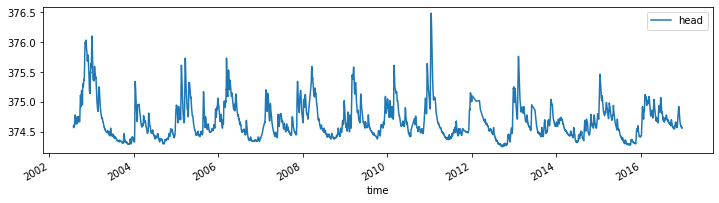

In [10]:
df_y.plot(figsize=(12,3))
plt.show()

In [11]:
df_X.columns

Index(['rr', 'tg', 'tn', 'tx', 'pp', 'hu', 'fg', 'qq', 'et', 'rr_avg_15',
       'rr_avg_30', 'rr_avg_90', 'tg_avg_15', 'tg_avg_30', 'tg_avg_90',
       'tn_avg_15', 'tn_avg_30', 'tn_avg_90', 'tx_avg_15', 'tx_avg_30',
       'tx_avg_90', 'pp_avg_15', 'pp_avg_30', 'pp_avg_90', 'hu_avg_15',
       'hu_avg_30', 'hu_avg_90', 'fg_avg_15', 'fg_avg_30', 'fg_avg_90',
       'qq_avg_15', 'qq_avg_30', 'qq_avg_90', 'et_avg_15', 'et_avg_30',
       'et_avg_90', 'day'],
      dtype='object')

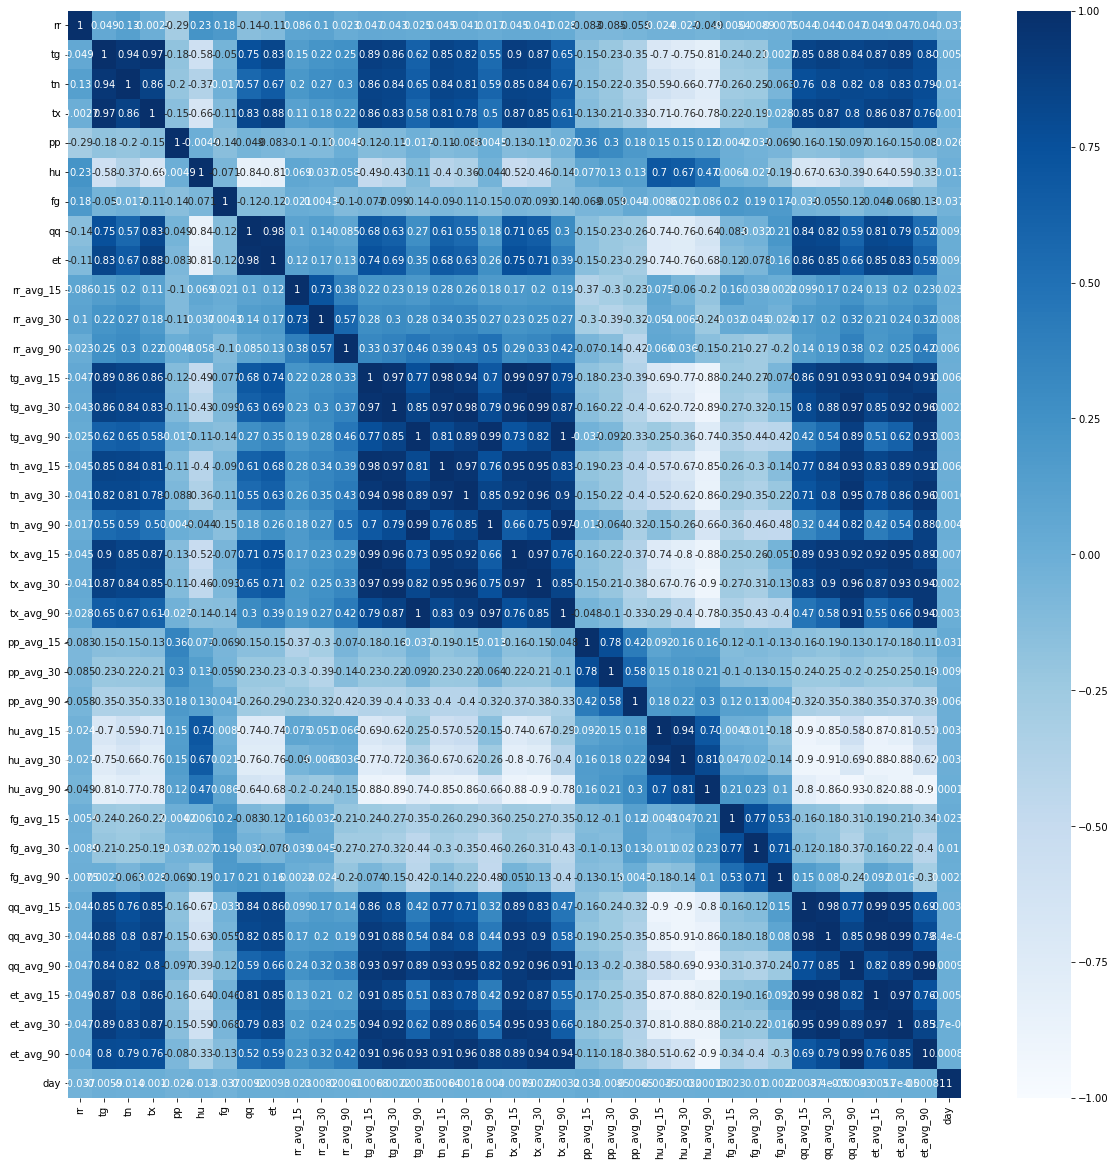

In [12]:
corr_matrix = df_X.corr()
plt.figure(figsize=(20,20))
# remember to always set the min max values! otherwise will be misleading
sns.heatmap(corr_matrix, cmap='Blues',vmin=-1,vmax=1, annot=True) 
plt.show()

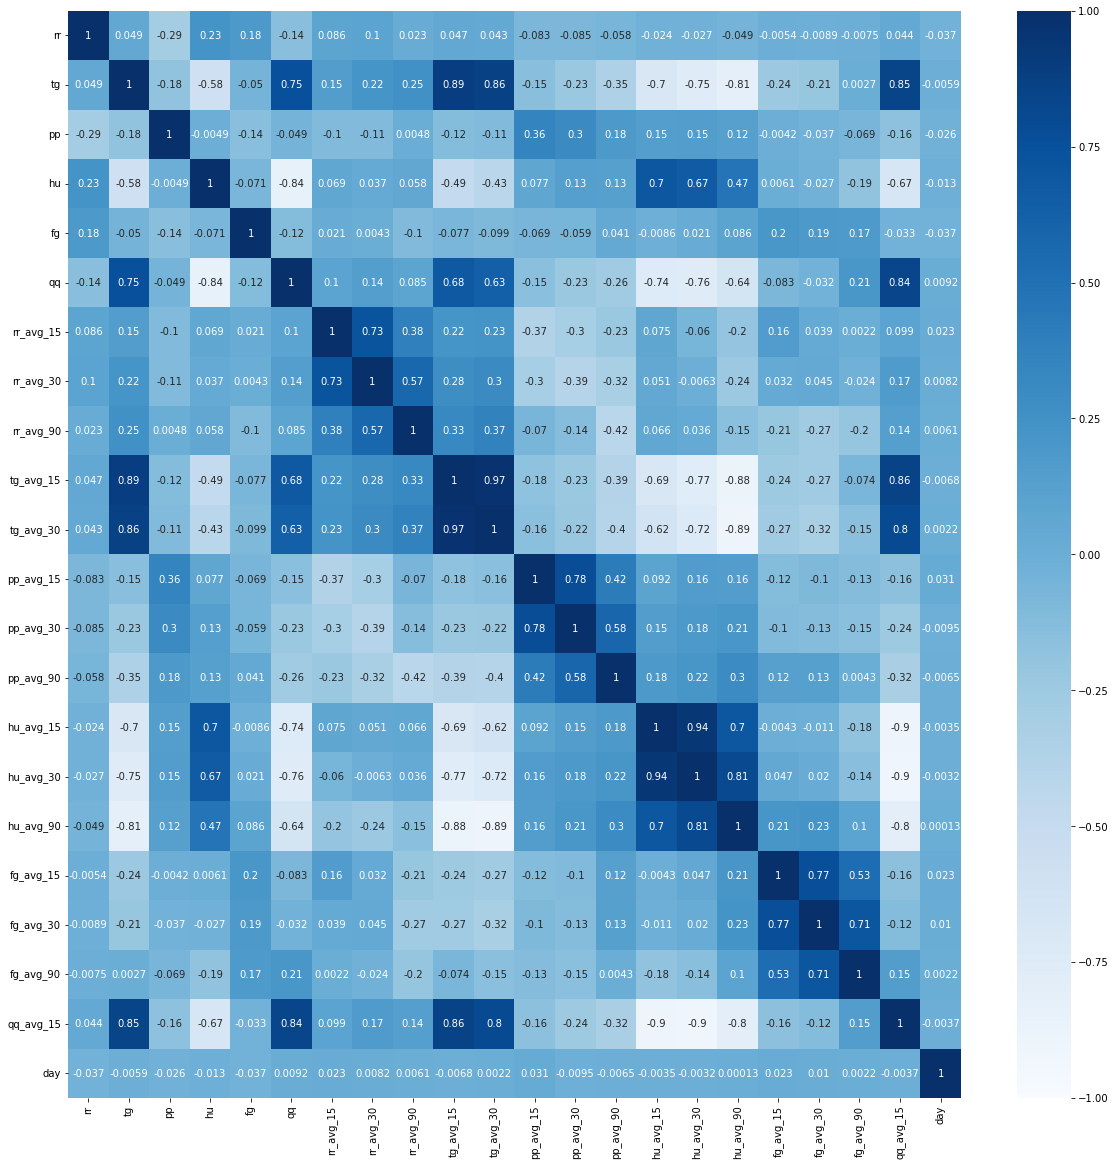

In [13]:
df_X = df_X.drop(columns=[col for col in df_X.columns if (col.startswith('tn') or col.startswith('tx') or col.startswith('et') or col in ['rr_min_7','qq_avg_30','tg_avg_90','qq_avg_90'])])
corr_matrix = df_X.corr()
plt.figure(figsize=(20,20))
# remember to always set the min max values! otherwise will be misleading
sns.heatmap(corr_matrix, cmap='Blues',vmin=-1,vmax=1, annot=True) 
plt.show()

# Modeling

### baseline predction score:

In [14]:
# split
df_y_train = df_y[df_y.index < '2014-01-01']
df_y_val = df_y[df_y.index >= '2014-01-01']

base_y_train = df_y_train
base_y_val = df_y_val

In [15]:
# calculate baseline RMSE
from sklearn.metrics import mean_squared_error

base_y_train['year'] = df_y_train.index.year
base_y_train['month'] = df_y_train.index.month
base_y_train['day'] = df_y_train.index.day

base_prediction = base_y_train.groupby(['month','day'])['head'].mean().reset_index()

base_y_val = df_y_val
base_y_val['month'] = df_y_val.index.month
base_y_val['day'] = df_y_val.index.day

base_y_val = pd.merge(base_y_val, base_prediction, on=['month','day'], how='left')
base_y_val.rename(columns={'head_x':'head_true','head_y':'head_pred'}, inplace=True)

baseline_RMSE = mean_squared_error(base_y_val['head_true'],base_y_val['head_pred'])
baseline_RMSE

/var/folders/s2/sf7955y100s0swq1st6g5clm0000gn/T/ipykernel_61829/2642000833.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_y_train['year'] = df_y_train.index.year
/var/folders/s2/sf7955y100s0swq1st6g5clm0000gn/T/ipykernel_61829/2642000833.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_y_train['month'] = df_y_train.index.month
/var/folders/s2/sf7955y100s0swq1st6g5clm0000gn/T/ipykernel_61829/2642000833.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

0.04459973105040526

In [16]:
df_y_train.index.year

Int64Index([2002, 2002, 2002, 2002, 2002, 2002, 2002, 2002, 2002, 2002,
            ...
            2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013],
           dtype='int64', name='time', length=3705)

# pipline

In [96]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb


# df_X_train = df_X[df_X.index<'2014-01-01']
# df_y_train = df_y[df_y.index<'2014-01-01']
# df_X_val = df_X[df_X.index>='2014-01-01']
# df_y_val = df_y[df_y.index>='2014-01-01']

# The function which takes the unprocessed feature matrix, target variable, 
# a preprocessor (ColumnTransformer), an initialized ML algorithm, and a correspondig parameter grid as inputs.
def MLpipe_KFold_RMSE(ColumnTransformer, ML_algorithm, parameter_grid):
    
    # collect all the encoders into one preprocessor
    preprocessor = ColumnTransformer

    prep = Pipeline(steps=[('preprocessor', preprocessor)]) 
    
    # Use GridSearchCV and the parameter names need to contain the ML algorithm
    param_grid = parameter_grid 
    
    nr_states = 1 # number of random states
    test_scores = np.zeros(nr_states)
    final_models = []

    for i in range(nr_states):
        # first split to separate out the test set
        # use kfold on other
        feature_matrix_other=df_X[df_X.index<'2014-01-01']
        feature_matrix_test=df_X[df_X.index>='2014-01-01']
        target_variable_other_df=df_y[df_y.index<'2014-01-01']
        target_variable_test_df=df_y[df_y.index>='2014-01-01']
        target_variable_other=target_variable_other_df.values.ravel()
        target_variable_test=target_variable_test_df.values.ravel()

        # splitter for other using k kfold
        tsp = TimeSeriesSplit(n_splits=4)

        # the classifier
        if ML_algorithm in [SVR, KNeighborsRegressor]:
            clf = ML_algorithm()
        else:
            clf = ML_algorithm(random_state = 42*i) # initialize the classifier  
        
        # put together a pipeline
        # the pipeline will fit_transform the training set (4 folds), and transform the last fold used as validation
        # then it will train the ML algorithm on the training set and evaluate it on the validation set
        # it repeats this step automatically such that each fold will be an evaluation set once
        pipe = make_pipeline(preprocessor,clf)

        # use GridSearchCV
        # GridSearchCV loops through all parameter combinations and collects the results 
        grid = GridSearchCV(pipe, param_grid=param_grid,scoring = 'neg_mean_squared_error',
                            cv=tsp, return_train_score = True, n_jobs=-1, verbose=True)
        
        # this line actually fits the model on other
        grid.fit(feature_matrix_other, target_variable_other)
        # save results into a data frame.
        results = pd.DataFrame(grid.cv_results_)
        #print(results)

        print('best model parameters:',grid.best_params_)
        #print('validation score:',grid.best_score_) # this is the mean validation score over all iterations
        final_models.append(grid)
        # calculate and save the test score
        target_variable_test_pred = final_models[-1].predict(feature_matrix_test)
        test_scores[i] = (mean_squared_error(target_variable_test,target_variable_test_pred)) #use RMSE as test score
        std_test = np.std(target_variable_test_pred)
        print('test score:',test_scores[i])
        
        ###train set plot
        target_variable_other_pred = final_models[-1].predict(feature_matrix_other)
        prediction = pd.DataFrame(target_variable_other_pred,index=target_variable_other_df.index)
        ax = target_variable_other_df.plot(figsize=(10,6))
        prediction.plot(ax=ax)
        plt.legend(["train_data","predict"])
        plt.title("trainset plot")
        plt.show()
        
        #test set plot
        prediction = pd.DataFrame(target_variable_test_pred,index=target_variable_test_df.index)
        ax = target_variable_test_df.plot(figsize=(10,6))
        prediction.plot(ax=ax)
        (prediction+1.96*std_test).plot(ax=ax,style="r:",alpha=0.6)
        (prediction-1.96*std_test).plot(ax=ax,style="g:",alpha=0.6)
        plt.legend(["test_data","predict","95% upper bound","95% lower bound"])
        plt.title("testset plot")
        plt.show()
    
    # print out mean and std of test scores
    print('mean of test scores:',np.mean(test_scores))
    #print('standard deviation of test scores:',np.std(test_scores))
    


Fitting 4 folds for each of 11 candidates, totalling 44 fits
best model parameters: {'lasso__alpha': 0.01}
test score: 0.020556621939984653


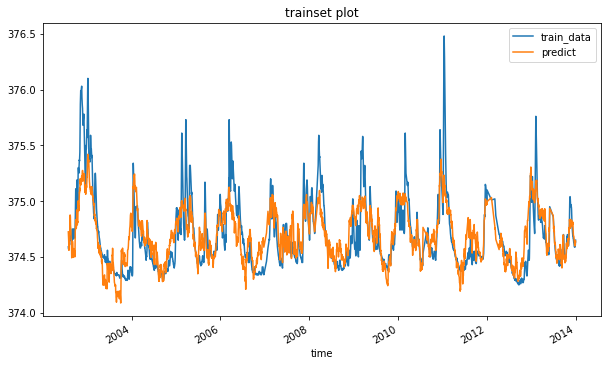

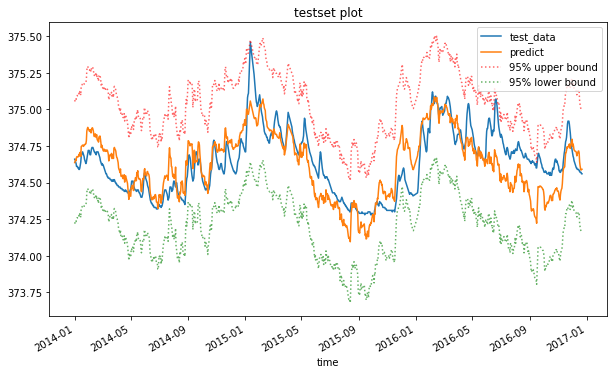

mean of test scores: 0.020556621939984653


In [97]:
# lasso regression with avg_past_week
onehot_ftrs = ['day']
std_ftrs = [col for col in df_X.columns if col not in onehot_ftrs]

columnTransformer=ColumnTransformer(transformers=[('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), 
                                                   onehot_ftrs),('std', StandardScaler(), std_ftrs)],remainder='passthrough')
ML_algorithm=Lasso
parameter_grid = {'lasso__alpha': np.logspace(-2,2,11)} 

MLpipe_KFold_RMSE(columnTransformer, ML_algorithm, parameter_grid)

Fitting 4 folds for each of 15 candidates, totalling 60 fits
best model parameters: {'svr__C': 0.1, 'svr__gamma': 0.01}
test score: 0.01997743451896117


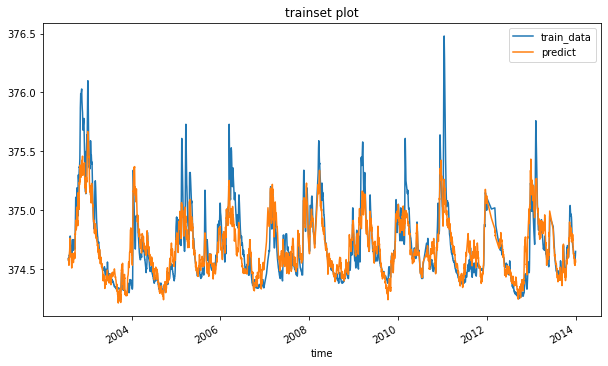

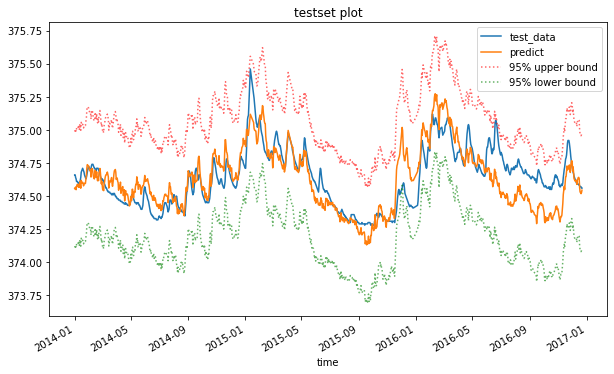

mean of test scores: 0.01997743451896117


In [98]:
# SVR
onehot_ftrs = ['day']
std_ftrs = [col for col in df_X.columns if col not in onehot_ftrs]
columnTransformer=ColumnTransformer(transformers=[('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_ftrs),
                                                  ('std', StandardScaler(), std_ftrs)],remainder='passthrough')
ML_algorithm=SVR
parameter_grid = {'svr__gamma': [1e-2, 1e-1, 1e1, 1e2, 1e3],'svr__C': [1e-1, 1e0, 1e1]} 

MLpipe_KFold_RMSE(columnTransformer, ML_algorithm, parameter_grid)

Fitting 4 folds for each of 30 candidates, totalling 120 fits
best model parameters: {'randomforestregressor__max_depth': 30, 'randomforestregressor__max_features': 0.25}
test score: 0.022530835820459477


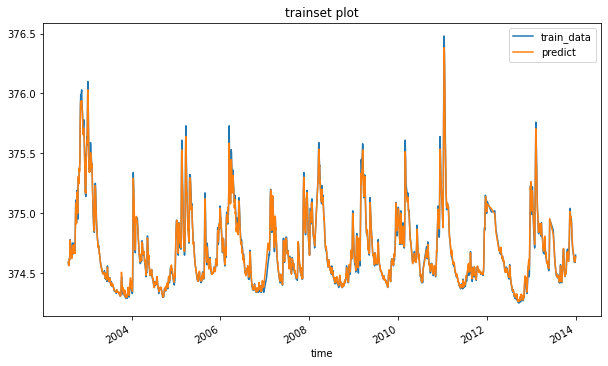

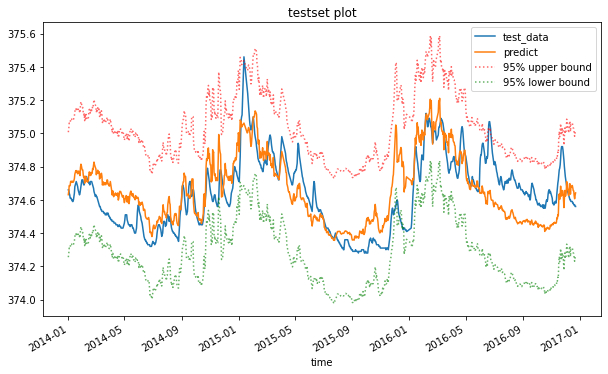

mean of test scores: 0.022530835820459477


In [99]:
# random forest
onehot_ftrs = ['day']
std_ftrs = [col for col in df_X.columns if col not in onehot_ftrs]
columnTransformer=ColumnTransformer(transformers=[('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_ftrs),
                                                  ('std', StandardScaler(), std_ftrs)],remainder='passthrough')
ML_algorithm=RandomForestRegressor
parameter_grid = {'randomforestregressor__max_depth': [1,5,10,30,50,100],'randomforestregressor__max_features': [0.01,0.25,0.5,0.75,1]} 

MLpipe_KFold_RMSE(columnTransformer, ML_algorithm, parameter_grid)

Fitting 4 folds for each of 4 candidates, totalling 16 fits
best model parameters: {'xgbregressor__colsample_bytree': 0.9, 'xgbregressor__eval_metric': 'rmse', 'xgbregressor__learning_rate': 0.05, 'xgbregressor__max_depth': 30, 'xgbregressor__missing': nan, 'xgbregressor__n_estimators': 1000, 'xgbregressor__subsample': 0.66}
test score: 0.020614815561274927


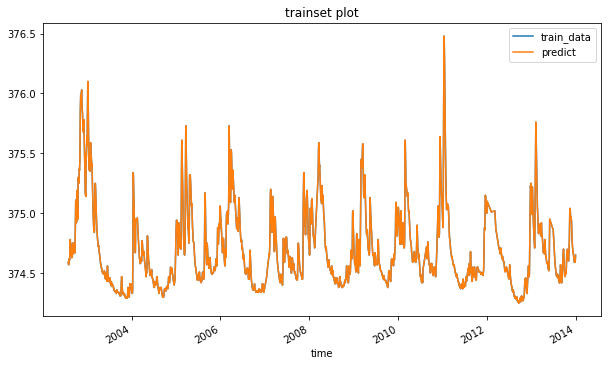

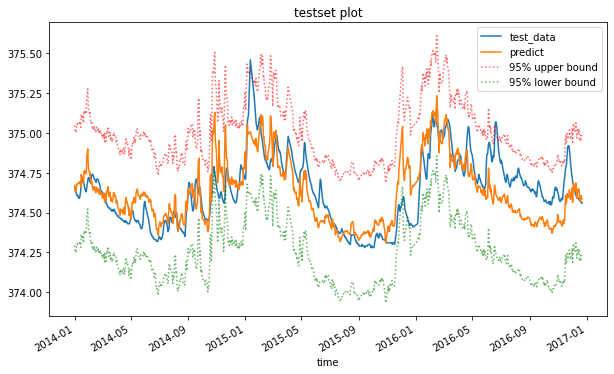

mean of test scores: 0.020614815561274927


In [100]:
# XGBOOST
onehot_ftrs = ['day']
std_ftrs = [col for col in df_X.columns if col not in onehot_ftrs]
columnTransformer=ColumnTransformer(transformers=[('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_ftrs),
                                                  ('std', StandardScaler(), std_ftrs)],remainder='passthrough')
ML_algorithm=xgb.XGBRegressor
parameter_grid = {'xgbregressor__max_depth': [1,3,10,30],
                  'xgbregressor__learning_rate': [0.05],
                 "xgbregressor__n_estimators": [1000],
                 "xgbregressor__missing": [np.nan], 
                 "xgbregressor__colsample_bytree": [0.9],
                 "xgbregressor__subsample": [0.66],
                  "xgbregressor__eval_metric":['rmse'],} 


MLpipe_KFold_RMSE(columnTransformer, ML_algorithm, parameter_grid)